# Vanilla SATNet(No auxilary variables, full rank)

- $n$ denotes the number of boolean variables, for sudoku $n=729$.
- $m$ denotes the rank of the clause matrix $S$.
- Caution! $S$ is transposed in this implementation (contrary to written in the paper).
- You need to calculate $C = S S^T$ as its gram matrix in python code, but in paper $C = S^T S$
- In this documentation, I will follow the convention for python implementation.
- Stucks at ~90% accuracy, converges quite slowly
- You may see $S$ by 
```
model = SudokuSolver(args.boardSz, args.aux, args.m)
S = model.sat.S
```
- $S = \begin{bmatrix}
v_0 & v_1 & \cdots & v_n & vaux_1 & \cdots & vaux_p
\end{bmatrix}^T$
    - $v_0$ is the truth variable
    - $v_1$ to $v_n$ are the sudoku variables
    - $vaux_1$ to $vaux_p$ are the place auxilary variables

- Logs are saved with accu/entropy graphs in .csv files and $S$ record with each epoch.

In this experiment, we use no auxilary variables and the full rank matrix $S$ (no low rank approximation)

In [1]:
# helpers

import argparse

import os
import shutil
import csv, time
import random, string

import numpy.random as npr
#import setproctitle

import matplotlib.pyplot as plt
from IPython.display import display
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from tqdm.autonotebook import tqdm

import satnet

class SudokuSolver(nn.Module):
    def __init__(self, boardSz, aux, m):
        super(SudokuSolver, self).__init__()
        n = boardSz**6
        self.sat = satnet.SATNet(n, m, aux)

    def forward(self, y_in, mask):
        out = self.sat(y_in, mask)
        return out

class CSVLogger(object):
    def __init__(self, fname):
        self.f = open(fname, 'a')
        self.fname = fname

    def log(self, fields):
        csv.writer(self.f).writerow(fields)
        self.f.flush()
        self.f.close()
        self.f = open(self.fname, 'a')

class FigLogger(object):
    def __init__(self, fig, base_ax, title):
        self.colors = ['tab:red', 'tab:blue']
        self.labels = ['Loss (entropy)', 'Error']
        self.markers = ['d', '.']
        self.axes = [base_ax, base_ax.twinx()]
        base_ax.set_xlabel('Epochs')
        base_ax.set_title(title)
        
        for i, ax in enumerate(self.axes):
            ax.set_ylabel(self.labels[i], color=self.colors[i])
            ax.tick_params(axis='y', labelcolor=self.colors[i])

        self.reset()
        self.fig = fig
        
    def log(self, args):
        for i, arg in enumerate(args[-2:]):
            self.curves[i].append(arg)
            x = list(range(len(self.curves[i])))
            self.axes[i].plot(x, self.curves[i], self.colors[i], marker=self.markers[i])
            self.axes[i].set_ylim(0, 1.05)
            
        self.fig.canvas.draw()
        
    def reset(self):
        for ax in self.axes:
            for line in ax.lines:
                line.remove()
        self.curves = [[], []]

def print_header(msg):
    print('===>', msg)


In [2]:
#Sudoku related functions and training code
def process_inputs(X, Y, boardSz):
    is_input = X.sum(dim=3, keepdim=True).expand_as(X).int().sign()

    X      = X.view(X.size(0), -1)
    Y      = Y.view(Y.size(0), -1)
    is_input = is_input.view(is_input.size(0), -1)

    return X, Y, is_input

def run(boardSz, epoch, model, optimizer, logger, figlogger, dataset, batchSz, to_train=False):
    loss_final, err_final = 0, 0

    loader = DataLoader(dataset, batch_size=batchSz)
    tloader = tqdm(enumerate(loader), total=len(loader))
    
    for i,(data,is_input,label) in tloader:
        if to_train: optimizer.zero_grad()
        preds = model(data.contiguous(), is_input.contiguous())
        loss = nn.functional.binary_cross_entropy(preds, label)

        if to_train:
            loss.backward()
            optimizer.step()

        err = computeErr(preds.data, boardSz)/batchSz
        tloader.set_description('Epoch {} {} Loss {:.4f} Err: {:.4f}'.format(epoch, ('Train' if to_train else 'Test '), loss.item(), err))
        loss_final += loss.item()
        err_final += err

    loss_final, err_final = loss_final/len(loader), err_final/len(loader)
    logger.log((epoch, loss_final, err_final))
    figlogger.log((epoch, loss_final, err_final))
    
    if to_train: 
        torch.save(model.sat.S, os.path.join('logs/S0_full', f'{epoch}.pt'))

    if not to_train:
        print('TESTING SET RESULTS: Average loss: {:.4f} Err: {:.4f}'.format(loss_final, err_final))
    
    #print('memory: {:.2f} MB, cached: {:.2f} MB'.format(torch.cuda.memory_allocated()/2.**20, torch.cuda.memory_cached()/2.**20))
    torch.cuda.empty_cache()

def train(args, epoch, model, optimizer, logger, figlogger, dataset, batchSz):
    run(args, epoch, model, optimizer, logger, figlogger, dataset, batchSz, True)

@torch.no_grad()
def test(args, epoch, model, optimizer, logger, figlogger, dataset, batchSz):
    run(args, epoch, model, optimizer, logger, figlogger, dataset, batchSz, False)

@torch.no_grad()
def computeErr(pred_flat, n):
    nsq = n ** 2
    pred = pred_flat.view(-1, nsq, nsq, nsq)

    batchSz = pred.size(0)
    s = (nsq-1)*nsq//2 # 0 + 1 + ... + n^2-1
    I = torch.max(pred, 3)[1].squeeze().view(batchSz, nsq, nsq)

    def invalidGroups(x):
        valid = (x.min(1)[0] == 0)
        valid *= (x.max(1)[0] == nsq-1)
        valid *= (x.sum(1) == s)
        return valid.bitwise_not()

    boardCorrect = torch.ones(batchSz).type_as(pred)
    for j in range(nsq):
        # Check the jth row and column.
        boardCorrect[invalidGroups(I[:,j,:])] = 0
        boardCorrect[invalidGroups(I[:,:,j])] = 0

        # Check the jth block.
        row, col = n*(j // n), n*(j % n)
        M = invalidGroups(I[:,row:row+n,col:col+n].contiguous().view(batchSz,-1))
        boardCorrect[M] = 0

        if boardCorrect.sum() == 0:
            return batchSz

    return float(batchSz-boardCorrect.sum())    

Using GeForce RTX 2080 Ti
===> Loading data
===> Forming inputs
===> Building model


  0%|          | 0/25 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.5071 Err: 1.0000


  0%|          | 0/225 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

TESTING SET RESULTS: Average loss: 0.1750 Err: 1.0000


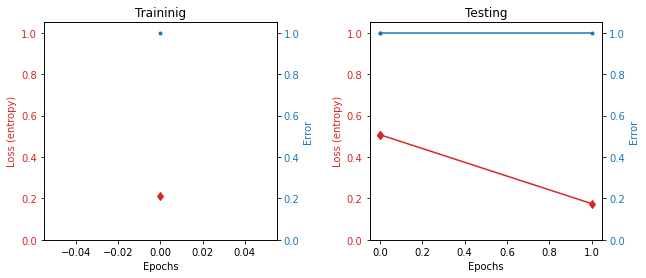

  0%|          | 0/225 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [3]:
# argument Parsers and main

def main():
    parser = argparse.ArgumentParser()
    parser.add_argument('--data_dir', type=str, default='sudoku')
    parser.add_argument('--boardSz', type=int, default=3)
    parser.add_argument('--batchSz', type=int, default=40)
    parser.add_argument('--testBatchSz', type=int, default=40)
    parser.add_argument('--aux', type=int, default=300)
    parser.add_argument('--m', type=int, default=600)
    parser.add_argument('--nEpoch', type=int, default=100)
    parser.add_argument('--testPct', type=float, default=0.1)
    parser.add_argument('--lr', type=float, default=2e-3)
    parser.add_argument('--save', type=str)
    parser.add_argument('--model', type=str)
    parser.add_argument('--no_cuda', action='store_true')

    # You may put the options here
    args = parser.parse_args(['--data_dir=sudoku','--aux=0', '--nEpoch=100', '--m=730'])

    # For debugging: fix the random seed
    # npr.seed(1)
    # torch.manual_seed(7)

    args.cuda = not args.no_cuda and torch.cuda.is_available()
    if args.cuda: 
        print('Using', torch.cuda.get_device_name(1))
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        torch.cuda.init()

    save = 'sudoku.boardSz{}-aux{}-m{}-lr{}-bsz{}-{}'.format(
            args.boardSz, args.aux, args.m, args.lr, args.batchSz, int(time.time()))
    if args.save: save = '{}-{}'.format(args.save, save)
    save = os.path.join('logs', save)
    if os.path.isdir(save): shutil.rmtree(save)
    os.makedirs(save)

    # setproctitle.setproctitle('sudoku.{}'.format(save))

    print_header('Loading data')

    with open(os.path.join(args.data_dir, 'features.pt'), 'rb') as f:
        X_in = torch.load(f)
    with open(os.path.join(args.data_dir, 'labels.pt'), 'rb') as f:
        Y_in = torch.load(f)

    N = X_in.size(0)
    nTrain = int(N*(1.-args.testPct))
    nTest = N-nTrain
    assert(nTrain % args.batchSz == 0)
    assert(nTest % args.testBatchSz == 0)

    print_header('Forming inputs')
    X, Y, is_input = process_inputs(X_in, Y_in, args.boardSz)
    data = X
    if args.cuda: data, is_input, Y = data.cuda(), is_input.cuda(), Y.cuda()

    train_set = TensorDataset(data[:nTrain], is_input[:nTrain], Y[:nTrain])
    test_set =  TensorDataset(data[nTrain:], is_input[nTrain:], Y[nTrain:])

    print_header('Building model')

    model = SudokuSolver(args.boardSz, args.aux, args.m)

    if args.cuda: model = model.cuda()
    optimizer = optim.Adam(model.parameters(), lr=args.lr)

    if args.model:
        model.load_state_dict(torch.load(args.model))

    train_logger = CSVLogger(os.path.join(save, 'train.csv'))
    test_logger = CSVLogger(os.path.join(save, 'test.csv'))
    fields = ['epoch', 'loss', 'err']
    train_logger.log(fields)
    test_logger.log(fields)

    plt.ioff()
    fig, axes = plt.subplots(1,2, figsize=(10,4))
    plt.subplots_adjust(wspace=0.4)
    figtrain_logger = FigLogger(fig, axes[0], 'Traininig')
    figtest_logger = FigLogger(fig, axes[1], 'Testing')
    
    
    test(args.boardSz, 0, model, optimizer, test_logger, figtest_logger, test_set, args.testBatchSz)
    for epoch in range(1, args.nEpoch+1):
        train(args.boardSz, epoch, model, optimizer, train_logger, figtrain_logger, train_set, args.batchSz)
        test(args.boardSz, epoch, model, optimizer, test_logger, figtest_logger, test_set, args.testBatchSz)
        display(fig)



if __name__=='__main__':
    main()

